# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [3]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [4]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [5]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [6]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [7]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [8]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [9]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [10]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [11]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-06-14,9472.9,9475.0,9230.6,9330.4,9361.6,2680.38680179,9347
1,2020-06-15,9328.4,9499.9,8905.0,9425.3,9216.4,9823.89428294,31566
2,2020-06-16,9425.3,9593.0,9385.0,9528.5,9494.5,5563.38048246,19545


In [12]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-06-01,31781.0,31929.0,29328.6,29790.0,30511.1,5171.21778074,31383
718,2022-06-02,29790.0,31449.2,29572.8,30427.0,30110.1,2470.22902272,19405
719,2022-06-03,30431.3,30658.9,30354.4,30501.1,30499.9,104.81439957,1713


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [13]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-06-14,9472.9,9475.0,9230.6,9330.4,2680.38680179,9347
1,2020-06-15,9328.4,9499.9,8905.0,9425.3,9823.89428294,31566
2,2020-06-16,9425.3,9593.0,9385.0,9528.5,5563.38048246,19545


<b> Select the data after March 31,2022 </b>

In [14]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [15]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [16]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [17]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3148,2022-06-01,31781.0,31929.0,29328.6,29790.0,5171.21778074,31383
3149,2022-06-02,29790.0,31449.2,29572.8,30427.0,2470.22902272,19405
3150,2022-06-03,30431.3,30658.9,30354.4,30501.1,104.81439957,1713


In [18]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3151 entries, 0 to 3150
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3151 non-null   datetime64[ns]
 1   open    3151 non-null   object        
 2   high    3151 non-null   object        
 3   low     3151 non-null   object        
 4   close   3151 non-null   object        
 5   volume  3151 non-null   object        
 6   trades  3151 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 172.4+ KB


In [19]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [20]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [21]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [22]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [23]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3149,2022-06-02,29790.0,31449.2,29572.8,30427.0,2470.229023,19405
3150,2022-06-03,30431.3,30658.9,30354.4,30501.1,104.814400,1713


In [24]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 0 to 3150
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3151 non-null   object 
 1   open    3151 non-null   float64
 2   high    3151 non-null   float64
 3   low     3151 non-null   float64
 4   close   3151 non-null   float64
 5   volume  3151 non-null   float64
 6   trades  3151 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 196.9+ KB


#### Split date column to year, month, day

In [25]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [26]:
btc_df = date_split(btc_df)

In [27]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [28]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [29]:
btc_df = btc_df.set_index("date")

In [30]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [31]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [32]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [33]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [34]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [35]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [36]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [37]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [38]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [39]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [40]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [41]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [42]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,2022,6,1,31781.0,31929.0,29328.6,29790.0,5171.217781,31383,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,2022,6,2,29790.0,31449.2,29572.8,30427.0,2470.229023,19405,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480
2022-06-03,2022,6,3,30431.3,30658.9,30354.4,30501.1,104.814400,1713,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020


#### Drop NaN

In [44]:
len(btc_df)

3151

In [45]:
btc_df = btc_df.dropna()

In [46]:
len(btc_df)

3101

In [47]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [48]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,2022,6,1,31781.0,31929.0,29328.6,29790.0,5171.217781,31383,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,2022,6,2,29790.0,31449.2,29572.8,30427.0,2470.229023,19405,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480
2022-06-03,2022,6,3,30431.3,30658.9,30354.4,30501.1,104.814400,1713,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020


#### Save dataframe for later use for Machine Learaning model

In [49]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [50]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [51]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,2022,6,1,31781.0,31929.0,29328.6,29790.0,5171.217781,31383,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,2022,6,2,29790.0,31449.2,29572.8,30427.0,2470.229023,19405,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480
2022-06-03,2022,6,3,30431.3,30658.9,30354.4,30501.1,104.814400,1713,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020


In [52]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [53]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [54]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-31,2022,5,31,31710.4,32400.0,31183.7,31780.9,3470.770769,30831,29450.5,32186.4,29281.8,31711.7,5654.097225,31318.0,0.014831,0.089034,0.016024,0.076783,3.374826,1.052159,29204.842857,30031.357143,28614.457143,29585.871429,3304.828668,22719.285714,-0.001572,-0.004396,-0.001593,-0.003697,0.081372,0.050747,29604.344444,29634.735,34963.328
2022-06-01,2022,6,1,31781.0,31929.0,29328.6,29790.0,5171.217781,31383,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,2022,6,2,29790.0,31449.2,29572.8,30427.0,2470.229023,19405,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480


<b> Close Price Trend </b>

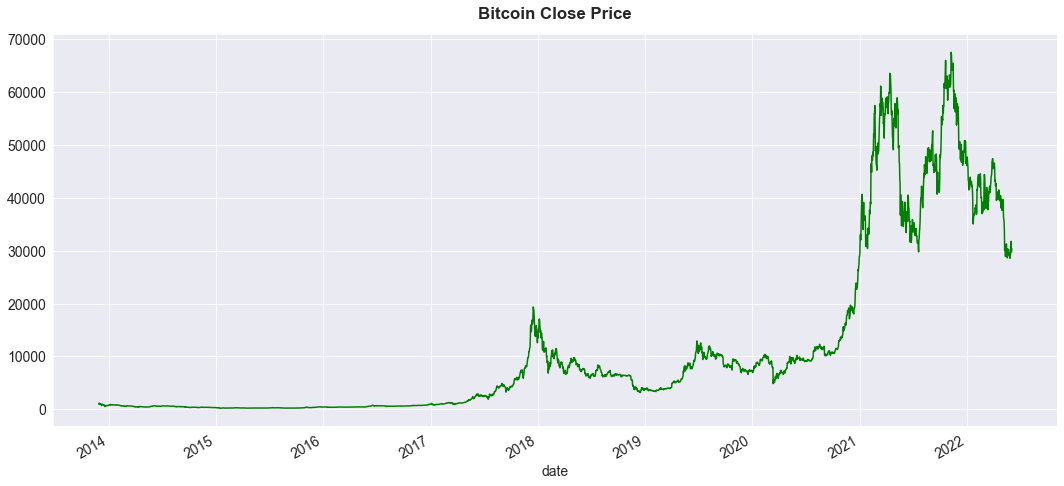

In [55]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

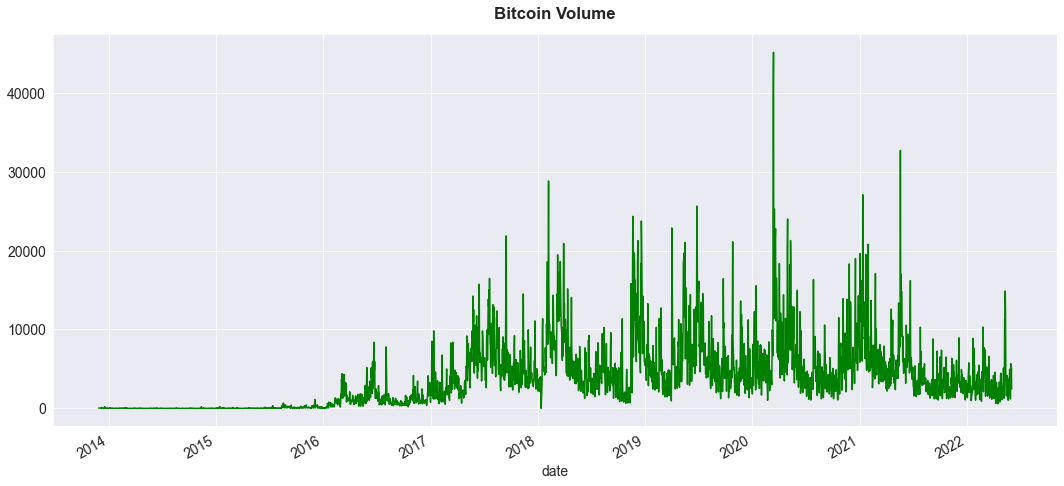

In [56]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

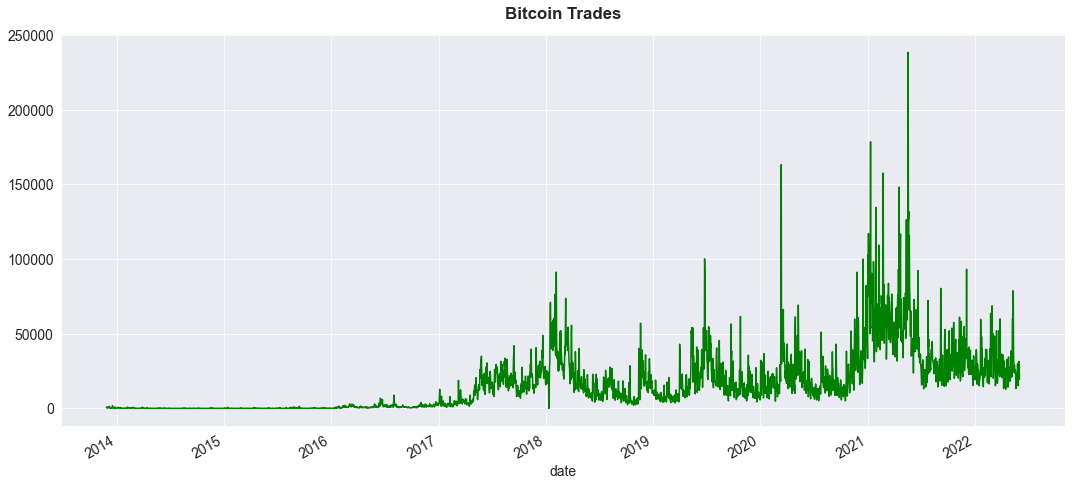

In [57]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

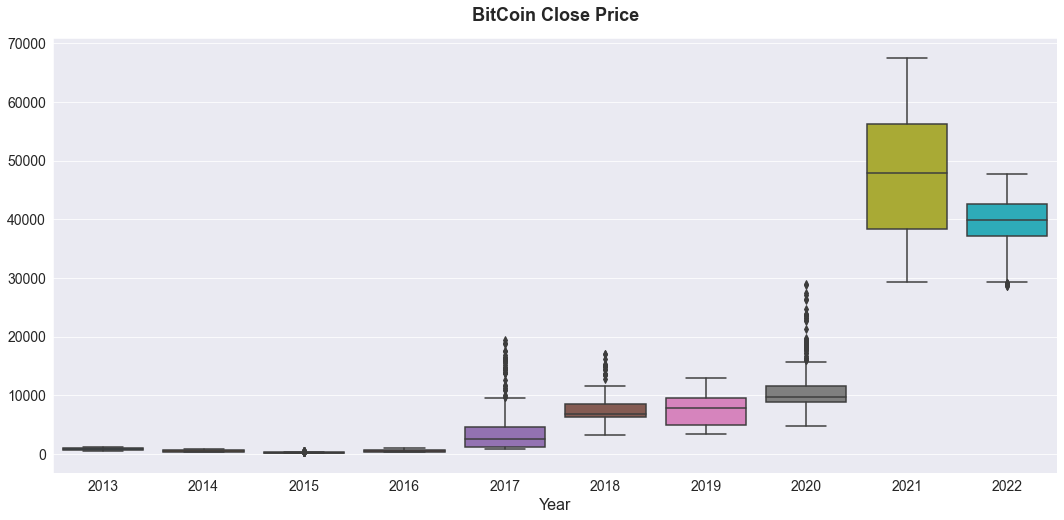

In [58]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

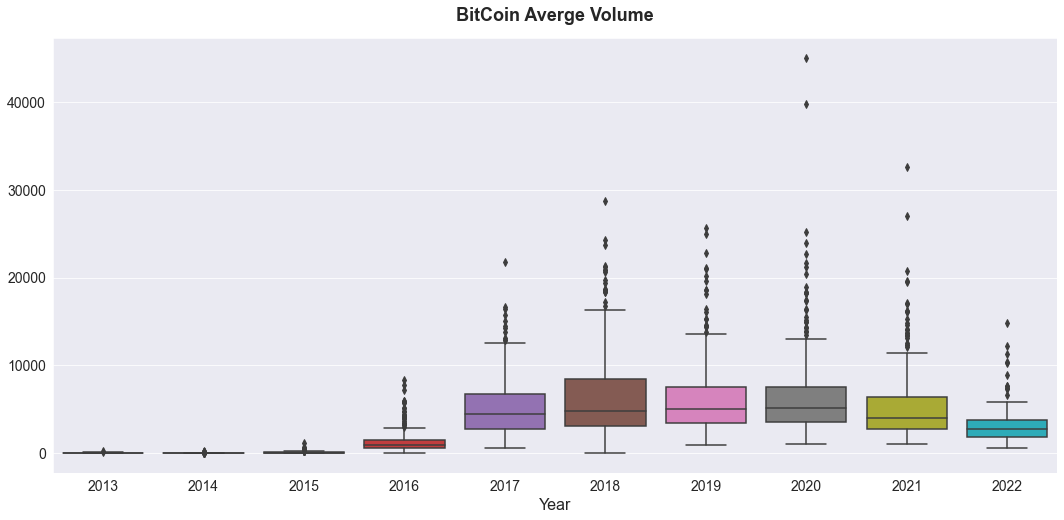

In [59]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

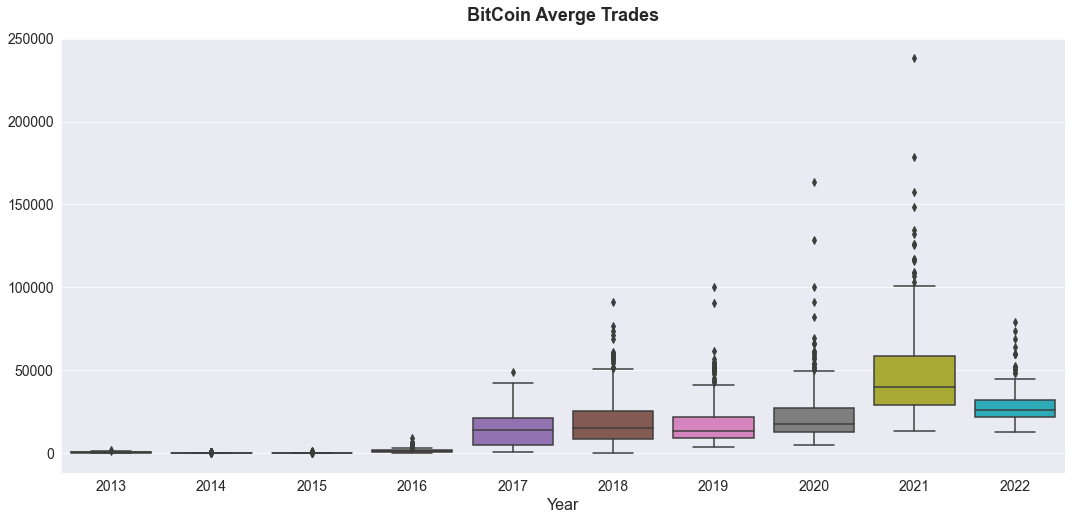

In [60]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [61]:
btc_df_viz_2022 = btc_df_viz[:]

In [62]:
filt = btc_df_viz_2022["year"]='2022'

In [63]:
btc_df_viz_2022 = btc_df_viz_2022[filt]

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_19084/3275679836.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022 = btc_df_viz_2022[filt]


Text(0, 0.5, '')

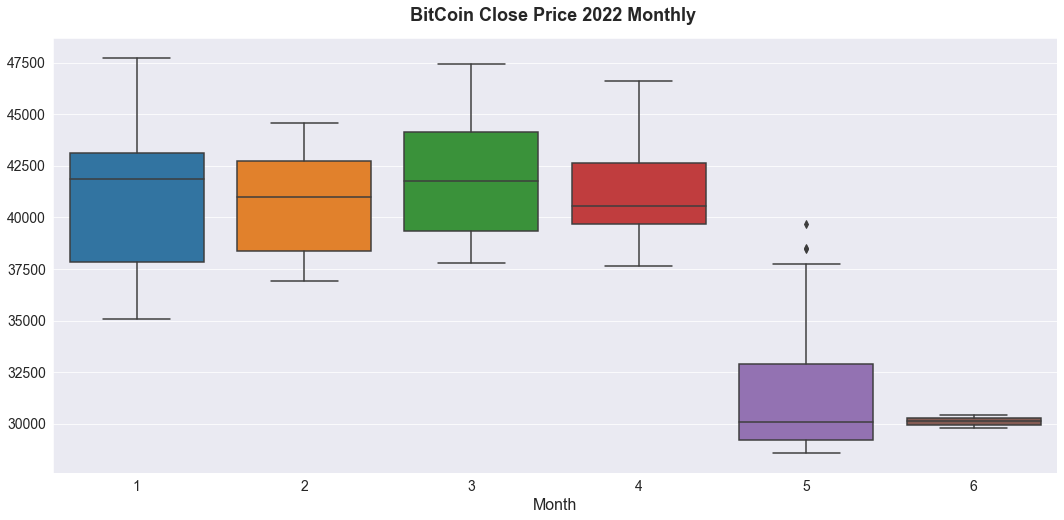

In [64]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [65]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [66]:
btc_avg = btc_df_viz[:]
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,2022,5,29,29020.10000,29555.00000,28820.00000,29450.40000,1292.416506,15261,28580.00000,29229.00000,28500.10000,29020.00000,1175.242850,15126.0,-0.020089,-0.005360,0.008853,0.015395,-0.733593,-0.495211,29374.585714,29944.114286,28607.800000,29325.285714,3011.243840,21543.142857,-0.005055,-0.006095,-0.001857,-0.002659,0.184102,0.082181,29316.444444,29630.400000,35438.566000
2022-05-30,2022,5,30,29450.50000,32186.40000,29281.80000,31711.70000,5654.097225,31318,29020.10000,29555.00000,28820.00000,29450.40000,1292.416506,15261.0,0.015399,0.011153,0.011225,0.014831,0.099702,0.008925,29321.114286,29809.114286,28549.842857,29208.485714,2929.804466,21477.142857,-0.002631,-0.001677,-0.001723,-0.001615,0.182577,0.074966,29347.877778,29599.145000,35172.294000
2022-05-31,2022,5,31,31710.40000,32400.00000,31183.70000,31780.90000,3470.770769,30831,29450.50000,32186.40000,29281.80000,31711.70000,5654.097225,31318.0,0.014831,0.089034,0.016024,0.076783,3.374826,1.052159,29204.842857,30031.357143,28614.457143,29585.871429,3304.828668,22719.285714,-0.001572,-0.004396,-0.001593,-0.003697,0.081372,0.050747,29604.344444,29634.735000,34963.328000


In [67]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

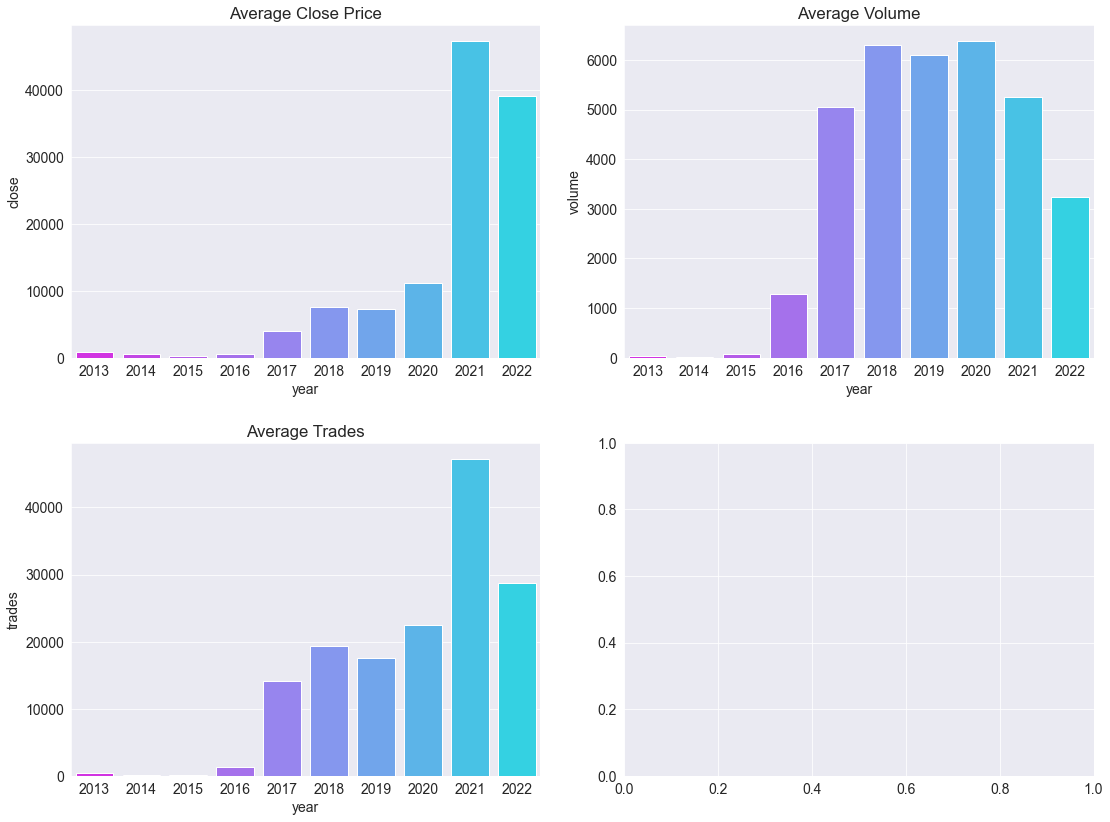

In [68]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [69]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [70]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

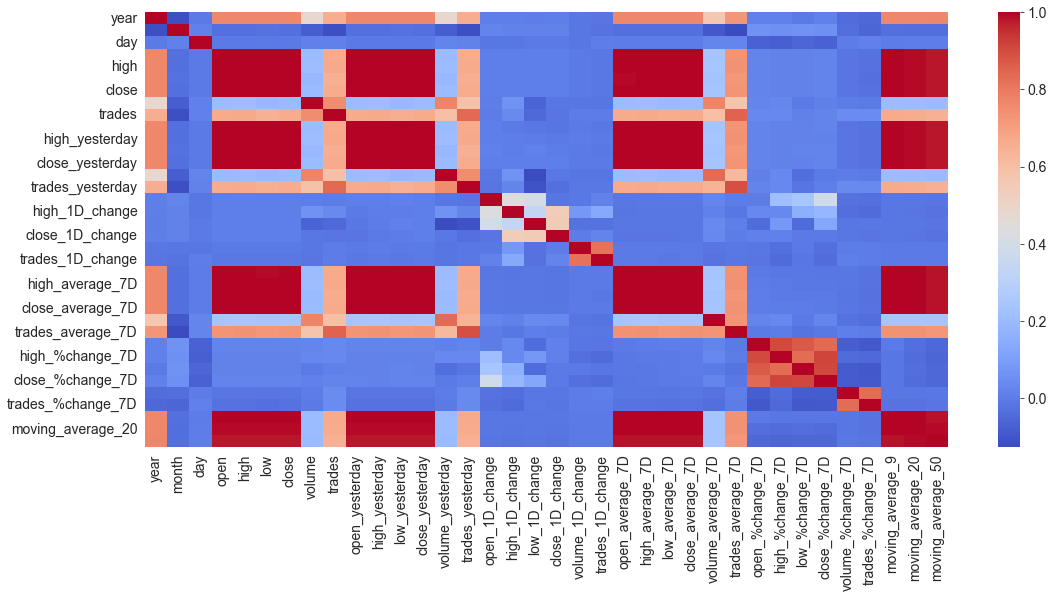

In [71]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [72]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [73]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [74]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [75]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [76]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [77]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [78]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,29790.0,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,30427.0,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480
2022-06-03,30501.1,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020


#### Drop the last row because we want to predict the price of the current day

In [79]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,30501.1,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.8,29876.625,34388.02


In [80]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [81]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,29790.0,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.77135,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,30427.0,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.04974,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [82]:
len(btc_ml)

3100

In [83]:
train_size = (85*(len(btc_ml)))//100
train_size

2635

**Train Set**

In [84]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-20,55938.7,51590.5,56349.9,50683.4,55926.9,8055.792485,75390.0,-0.010349,0.072206,-0.004338,0.083836,0.956141,0.649275,49162.385714,51321.700000,48089.9,50380.457143,5313.325157,57693.571429,0.022243,0.011168,0.021209,0.010834,-0.011358,-0.039355,49788.488889,43955.345,38469.034
2021-02-21,57478.3,55926.5,57500.0,53961.9,55938.7,5846.246813,68544.0,0.084046,0.020410,0.064686,0.000211,-0.274280,-0.090808,50375.000000,52646.828571,49186.6,51628.857143,5772.530574,61861.857143,0.010760,0.020834,0.013400,0.024277,0.172429,0.080711,50674.700000,45096.180,38999.830
2021-02-22,54154.8,55931.5,58339.0,55490.5,57478.3,3727.835736,45876.0,0.000089,0.014591,0.028327,0.027523,-0.362354,-0.330707,51622.371429,53880.971429,50394.0,52890.085714,5797.491088,61187.857143,0.024379,0.025796,0.022573,0.025122,0.205594,0.118804,51786.688889,46293.400,39504.620


**Test Set**

In [85]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-23,48899.8,57475.9,57567.6,45002.0,54154.8,12299.535705,125363.0,0.027612,-0.013223,-0.189014,-0.057822,2.299377,1.732649,52882.442857,55098.728571,50292.785714,53778.328571,6791.996297,70336.000000,0.025110,0.023508,0.024293,0.024665,0.103820,0.030814,52559.455556,47226.140,39926.062
2021-02-24,49727.7,54128.0,54200.0,45000.0,48899.8,17080.212490,157669.0,-0.058249,-0.058498,-0.000044,-0.097037,0.388688,0.257700,53766.857143,55613.028571,50001.342857,53732.771429,8349.809410,83729.714286,0.024649,0.023507,0.001325,0.018498,0.360539,0.248032,52587.244444,47787.585,40263.098
2021-02-25,47061.5,48899.6,51442.5,47015.7,49727.7,8110.232977,75094.0,-0.096593,-0.050876,0.044793,0.016931,-0.525168,-0.523724,53726.000000,55422.014286,49722.528571,53389.585714,8462.580260,84806.714286,0.018437,0.010616,-0.002837,0.000816,0.393652,0.278820,52786.200000,48425.020,40576.652


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [86]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [87]:
X_train = X_train_new.values
X_train.shape

(2635, 27)

<b>X_test</b>

In [88]:
X_test_new = test_set.drop(["close"], axis=1)

In [89]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-23,57475.9,57567.6,45002.0,54154.8,12299.535705,125363.0,0.027612,-0.013223,-0.189014,-0.057822,2.299377,1.732649,52882.442857,55098.728571,50292.785714,53778.328571,6791.996297,70336.000000,0.025110,0.023508,0.024293,0.024665,0.103820,0.030814,52559.455556,47226.140,39926.062
2021-02-24,54128.0,54200.0,45000.0,48899.8,17080.212490,157669.0,-0.058249,-0.058498,-0.000044,-0.097037,0.388688,0.257700,53766.857143,55613.028571,50001.342857,53732.771429,8349.809410,83729.714286,0.024649,0.023507,0.001325,0.018498,0.360539,0.248032,52587.244444,47787.585,40263.098
2021-02-25,48899.6,51442.5,47015.7,49727.7,8110.232977,75094.0,-0.096593,-0.050876,0.044793,0.016931,-0.525168,-0.523724,53726.000000,55422.014286,49722.528571,53389.585714,8462.580260,84806.714286,0.018437,0.010616,-0.002837,0.000816,0.393652,0.278820,52786.200000,48425.020,40576.652


In [90]:
X_test = X_test_new.values
X_test.shape

(465, 27)

<b> y_train </b>

In [91]:
y_train_new = train_set["close"]

In [92]:
y_train = y_train_new.values
y_train.shape

(2635,)

<b>y_test</b>

In [93]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(465,)

## Support Vector Machine

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [95]:
scaler = StandardScaler()

In [96]:
X_scaled_train = scaler.fit_transform(X_train)

In [97]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [98]:
svr_base1 = SVR()

In [99]:
svr_base1.fit(X_train , y_train)

SVR()

In [100]:
pred_base1 = svr_base1.predict(X_test)

In [101]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

43978.87900369599


In [102]:
print(r2_score(y_test, pred_base1))

-20.894069430996687


### Base Model2: Scale but Not Adjust Parameters

In [103]:
svr_base2 = SVR()

In [104]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [105]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [106]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

43885.26259346278


In [107]:
print(r2_score(y_test, pred_base2))

-20.800958250064735


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [108]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [109]:
svr = SVR()

In [110]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 57 µs, sys: 22 µs, total: 79 µs
Wall time: 92 µs


In [111]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 21s, sys: 382 ms, total: 1min 22s
Wall time: 1min 22s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [112]:
%%time
print(grid_search.best_params_)

{'C': 300, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 164 µs, sys: 120 µs, total: 284 µs
Wall time: 262 µs


In [113]:
svr_best = grid_search.best_estimator_

In [114]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [115]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1783.717854797235


In [116]:
print(r2_score(y_test, pred_svr_adjusted))

0.9639844128240449


In [117]:
len(y_test)

465

In [118]:
len(pred_svr_adjusted)

465

In [119]:
test_set["close"]

date
2021-02-23    48899.8
2021-02-24    49727.7
2021-02-25    47061.5
2021-02-26    46314.5
2021-02-27    46170.2
               ...   
2022-05-29    29450.4
2022-05-30    31711.7
2022-05-31    31780.9
2022-06-01    29790.0
2022-06-02    30427.0
Name: close, Length: 465, dtype: float64

In [120]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [121]:
df_compare

,actual_price,predicted_price


In [122]:
df_compare["actual_price"] = test_set["close"]

In [123]:
df_compare["predicted_price"] = pred_svr_adjusted

In [124]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [125]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-02-23,48899.8,53300.985640,-4401.185640
2021-02-24,49727.7,49835.356592,-107.656592
2021-02-25,47061.5,50001.972491,-2940.472491
2021-02-26,46314.5,48685.058959,-2370.558959
2021-02-27,46170.2,46737.966185,-567.766185
2021-02-28,45245.4,46734.403108,-1489.003108
2021-03-01,49620.7,45303.922851,4316.777149
2021-03-02,48486.2,48674.864567,-188.664567
2021-03-03,50400.0,48602.944437,1797.055563


In [126]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-05-19,30280.7,28959.329137,1321.370863
2022-05-20,29167.5,29773.683753,-606.183753
2022-05-21,29403.5,29277.391302,126.108698
2022-05-22,30268.0,29204.988281,1063.011719
2022-05-23,29070.0,29938.153870,-868.153870
2022-05-24,29631.8,29286.278565,345.521435
2022-05-25,29520.3,29349.635753,170.664247
2022-05-26,29186.9,29559.860382,-372.960382
2022-05-27,28580.0,28895.647378,-315.647378


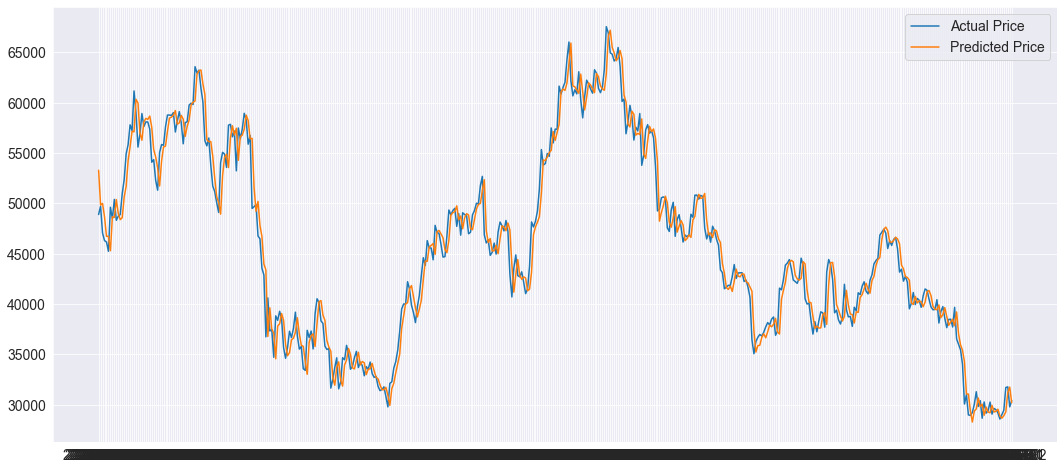

In [127]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [128]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [129]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,29790.0,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.77135,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,30427.0,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.04974,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [130]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [131]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,31710.4,32400.0,31183.7,31780.9,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.77135,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075,34808.254
2022-06-02,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.04974,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.480


In [132]:
X_train2 = X_train_new2.values
X_train2.shape

(3100, 27)

<b> y_train </b>

In [133]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3100,)

#### 3. Test set is current trading day , today ( the last row)

In [134]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.8,29876.625,34388.02


<b> y_actual </b>

#### 4. Model Prediciton

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [136]:
scaler = StandardScaler()

In [137]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [138]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [139]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [140]:
svr2 = SVR()

In [141]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 68 µs, sys: 87 µs, total: 155 µs
Wall time: 168 µs


In [142]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 26s, sys: 358 ms, total: 1min 26s
Wall time: 1min 26s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [143]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 29 µs, sys: 7 µs, total: 36 µs
Wall time: 30 µs


In [144]:
svr_best2 = grid_search2.best_estimator_

In [145]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [146]:
pred_svr_adjusted2

array([30475.5500978])

#### Create a new dataframe 

In [147]:
new_cols = ["date","predict", "actual"]

In [148]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [149]:
df_actual["date"] = last_row.index
df_actual

,date,predict,actual
0,2022-06-03,NaN,NaN


In [150]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-06-03,30475.550098,NaN


## Run Every Day

### Run at the End Of Day ( 5 p.m. Pacific Time)

In [151]:
daily_predict = pd.read_csv("data/daily_predict.csv", index_col=0)
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,NaN,NaN


### Actual Result

In [152]:
actual_close = btc_ml["close"][-1]
actual_close

30427.0

In [153]:
#daily_predict.set_index("date")

In [154]:
daily_predict["actual"][-1:] =  actual_close
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_19084/2655483848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_predict["actual"][-1:] =  actual_close


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,NaN


In [155]:
daily_predict["difference"] = daily_predict["predict"] - daily_predict["actual"]
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694


### Store Updated data everyday

In [156]:
daily_predict = daily_predict.append(df_actual, ignore_index=True)
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_19084/4107255893.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_predict = daily_predict.append(df_actual, ignore_index=True)


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,NaN,NaN


In [157]:
daily_predict.to_csv("data/daily_predict.csv")